In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### (I) Library imports

In [12]:
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from sklearn.neighbors import KNeighborsClassifier
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
from prettytable import PrettyTable
import operator
from sklearn.cluster import KMeans
from geoplotlib import colors
import json
#import mpld3
%matplotlib inline

### (II) Load the dataset

We made an intensive use of Pandas and its structures to handle the dataset, clean it and play with it.

In [13]:
# Load it into a Dataframe using pandas
path = '311_cleaned_2.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Location_Type,Complaint_Type,City,...,Latitude,Longitude,Location,Created_Date_date_time,year,month,Created_Year,Closed_Year,Call_Duration,Created_Hour
0,0,52494258,11/12/2021 11:32:03 PM,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",2021-11-12 23:32:03,2021,11,2021,2021,29.733333,23
1,1,52494267,11/12/2021 10:51:56 PM,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,RIDGEWOOD,...,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",2021-11-12 22:51:56,2021,11,2021,2021,195.416667,22
2,2,52494269,11/12/2021 09:52:21 PM,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Street/Sidewalk,Noise - Street/Sidewalk,NEW YORK,...,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",2021-11-12 21:52:21,2021,11,2021,2021,53.900000,21
3,3,52762434,12/10/2021 11:07:33 PM,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Residential Building/House,Noise - Residential,BRONX,...,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",2021-12-10 23:07:33,2021,12,2021,2021,8.733333,23
4,6,47668843,09/24/2020 12:53:51 AM,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Residential Building/House,Noise - Residential,BRONX,...,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)",2020-09-24 00:53:51,2020,9,2020,2020,79.600000,0


In [14]:
df.columns

Index(['Unnamed: 0', 'Unique_Key', 'Created_Date', 'Closed_Date', 'Agency',
       'Agency_Name', 'Descriptor', 'Location_Type', 'Complaint_Type', 'City',
       'Resolution_Description', 'Resolution_Action_UpdatedDate', 'zipcode',
       'Borough', 'Latitude', 'Longitude', 'Location',
       'Created_Date_date_time', 'year', 'month', 'Created_Year',
       'Closed_Year', 'Call_Duration', 'Created_Hour'],
      dtype='object')

### 3.3) Clustering
We will try to perform clustering on the complaint type **UNSANITARY CONDITION**. Below you can see the results obtained by trying to cluster the data points, from $K=2$ to $K=10$ (where $K$ = number of clusters).

In [15]:
a = list(df.Complaint_Type.unique())


In [16]:
df_kmeans = df[((df['Complaint_Type']!='Collection Truck Noise')&(df['Complaint_Type']!='Noise - House of Worship'))]
df_kmeans = df_kmeans.filter(items=['Complaint_Type','Latitude','Longitude'])

#Extract just a subset of the whole dataframe (since we have a lot of entries, it's a reasonable choice)
num_samples = 10000
df_kmeans = df_kmeans.sample(num_samples)

In [17]:
# Assign X and Y to K-means classifier
X = np.array(df_kmeans[['Latitude','Longitude']])

# Initialize the KMeans algorithm and fit
def k_means_func(n_clusters):
    clf = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return clf

In [18]:
# Create a cluster reference for each K
K_min = 2
K_max = 10

#Create dictionary of centroids
centroids = {}
for i in range(K_min,K_max+1):
    clf = k_means_func(i)
    centroids[str(i)+'_clusters'] = clf.cluster_centers_.tolist()
    df_kmeans[str(i)+'_clusters'] = pd.Series(clf.labels_, index=df_kmeans.index)
df_kmeans.head()

,Complaint_Type,Latitude,Longitude,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,9_clusters,10_clusters
82940,Noise - Residential,40.701773,-73.781310,0,2,3,2,4,4,4,2,5
701434,Noise - Residential,40.713340,-73.982772,0,0,2,4,0,0,5,8,6
147738,Noise - Street/Sidewalk,40.638219,-73.955815,0,0,2,3,2,6,1,1,7
103506,Noise - Residential,40.758264,-73.827136,1,2,3,2,4,4,2,5,8
438011,Noise - Residential,40.797756,-73.963471,1,1,0,4,3,3,3,0,1


In [19]:
#Save files for D3 visualization
df_clusters = df_kmeans.drop(['Complaint_Type'],axis=1)

with open('centroids.json', 'w') as outfile:  
    json.dump(centroids, outfile)
    
# Save the clusters and coordinates into a csv
df_clusters.to_csv('clusters.csv',index=False)

We hereby just show a preview of the clustering results, but in the D3 visualization there will be a more dynamic and fancy representation.

In [20]:
def dot_plot(df_geo_data_plot,geo_data_bounding,n_clusters):
    '''Plot the dotplot on a map'''
    #colors = ['red', 'green', 'blue','black','#ffff00', '#ff6600', '#ff66ff','#663300','#737373','#660033']
    
    # Create a dictionary and put each complaint's coordinates as a separate key,value pair and plot the KDE
    geo_dict = {}
    for cluster in range(n_clusters):
        geo_data_for_plotting = {"lat": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['Latitude'])], 
                                 "lon": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['Longitude'])]}
        geo_dict[cluster] = geo_data_for_plotting
        
    unique_clusters = list(df_geo_data_plot[str(n_clusters)+'_clusters'].unique())
    _colors = colors.colorbrewer(unique_clusters)
    for i,cluster in enumerate(unique_clusters):
        geoplotlib.dot(geo_dict[cluster], color=_colors[i], point_size=3)

    bbox = BoundingBox(north=max(geo_data_bounding['lat']),
                       west=min(geo_data_bounding['lon']),
                       south=min(geo_data_bounding['lat']),
                       east=max(geo_data_bounding['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.show()
    
geo_data_for_bounding_box = {"lat": [float(el) for el in list(df['Latitude'])],
                             "lon": [float(el) for el in list(df['Longitude'])]}

In [24]:
# Plot the 3 maps for K = 2,3 and 4
for i in range(K_min,11):
    dot_plot(df_kmeans,geo_data_for_bounding_box,i)

We can identify the optimal number of clusters by analizing the mean square error and how does it change as a function of K:

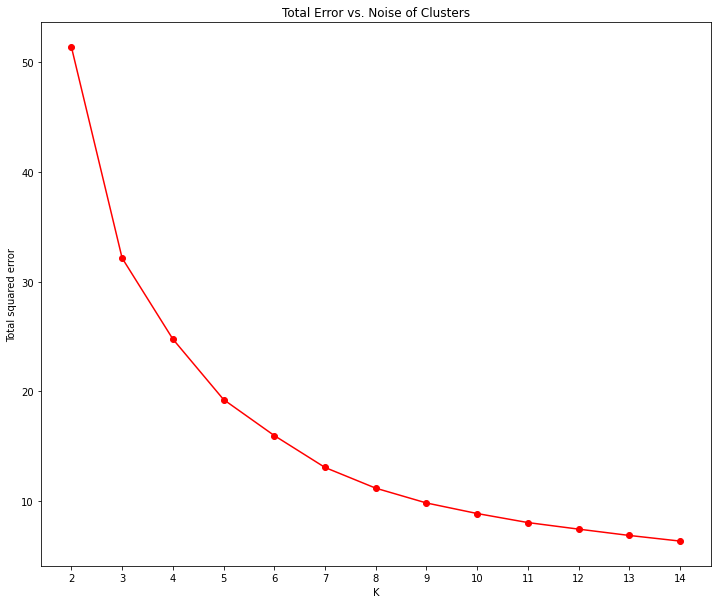

In [26]:
def squared_errors(k):
    clf = k_means_func(k)
    return clf.inertia_

ks = range(K_min,15)
errors = [squared_errors(k) for k in ks]
plt.figure(figsize=(12,10))
plt.plot(ks, errors,'r-o')
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Total squared error")
plt.title("Total Error vs. Noise of Clusters")
plt.show()

Of course the KMeans algorithm works better with a very high number of clusters, because the data is not particularly clustered and we have a lot of data points that are close to each other. Therefore, by increasing the number of K, we should always achieve a better result, and apparently even after `K = 50` we should still have some improvement, according to the trend of the above curve.